# QMF: Final Project

*By Basri, Clara, Daniel, Elisa, José, Karim, Nani*

In [1]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import yfinance as yf


In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'Ubuntu',
    'font.monospace': 'Ubuntu Mono',
    'font.size': 14,

    'axes.labelweight': 'normal',
    'axes.labelcolor': 'black',
    'axes.titleweight': 'normal',
    'axes.titlesize': 16,
    'axes.titlelocation': 'center',
    'axes.labelpad': 10,
    'axes.titleweight': 'bold',
    'axes.titlepad': 15,
    
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    
    'figure.titlesize': 18,
    'figure.figsize': (10, 6),
    'figure.autolayout': True,
    'figure.subplot.wspace': 0.25,
    'figure.subplot.wspace': 0.4,

    'lines.linewidth': 2
})

## Data Loading

In [3]:
# load stocks from yahoo finance
stocks = yf.download(
    "BNP.PA ACA.PA GLE.PA CS.PA AMUN.PA CNP.PA ^STOXX50E",
    start="2017-06-01")['Close']

# calculate daily returns
returns = (stocks / stocks.shift(1) - 1)

# format date column and drop nan values
stocks = stocks.reset_index().rename(columns = {'Date': 'date'})
returns = returns.dropna().reset_index().rename(columns = {'Date': 'date'})

[*********************100%***********************]  7 of 7 completed


In [4]:
df_covid_vaccines = pd.read_csv(
    "https://www.data.gouv.fr/fr/datasets/r/fa4ad329-14ec-4394-85a4-c5df33769dff", 
    sep=';', 
    names=['fra', 'date', '_', '__', '___', 'n_first_dose', 'n_second_dose', 'n_third_dose', '____', '_____', '______'], 
    usecols=['date', 'n_first_dose', 'n_second_dose', 'n_third_dose'], 
    skiprows=1, 
    parse_dates=['date']
)

In [5]:
df_covid_indicators = pd.read_csv(
    "https://www.data.gouv.fr/fr/datasets/r/f335f9ea-86e3-4ffa-9684-93c009d5e617", 
    usecols=['date', 'dc_tot', 'pos', 'TO', 'R'],  
    parse_dates=['date']
)
df_covid_indicators.rename(columns={'date': 'date', 'dc_tot': 'n_deaths', 'pos': 'n_cases', 'TO': 'hosp_occupation_rate', 'R': 'virus_reproduction_factor'}, inplace=True)
df_covid_indicators.fillna(0, inplace=True)

In [6]:
df_covid_measures_france = pd.read_csv(
    'datasets/covid_measures.csv',
    names = [
        'date', 'schools_closed', 'restaurants_museums_closed',
        'lockdown', 'curfew', 'travel_restriction',
        'emergency', 'lift_emergency', 'health_pass'
        ],
    parse_dates=[0],
    skiprows=1
    )

In [7]:
df_world_news = pd.read_csv('datasets/international_news.csv', sep=';', parse_dates=[0]).rename(columns={'Dates': 'date'})

## Data Processing

### Calculate abnormal returns

In [8]:
window = 244
abn_returns = pd.DataFrame(index = returns.date)
banks = ['ACA.PA', 'AMUN.PA', 'BNP.PA', 'CNP.PA', 'CS.PA', 'GLE.PA']

for bank in banks:
    for t in range(window, len(returns)):
        past_values = returns.iloc[t-window: t-5].copy()
        past_values['const'] = 1
        
        results = sm.OLS(past_values[bank], past_values[['const', '^STOXX50E']]).fit()
        alpha = results.params[0]
        beta = results.params[1]

        current_date = returns['date'].iloc[t]
        abn_returns.loc[current_date, bank] = returns[bank].iloc[t] - alpha - beta*returns['^STOXX50E'].iloc[t]

abn_returns = abn_returns.dropna()
abn_returns['avg_abn_returns'] = abn_returns.mean(axis=1)
abn_returns['cum'] = abn_returns['avg_abn_returns'].rolling(window=window).mean()
abn_returns = abn_returns.reset_index()

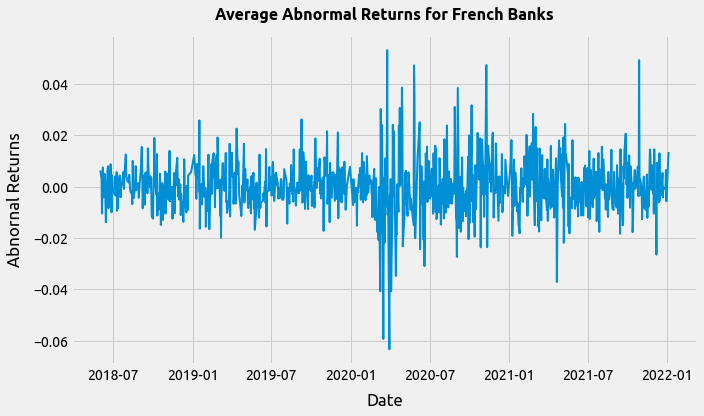

In [9]:
# plot abnormal returns
plt.figure()

plt.title('Average Abnormal Returns for French Banks')
plt.plot(abn_returns['date'], abn_returns['avg_abn_returns'])
plt.ylabel('Abnornal Returns')
plt.xlabel('Date')

plt.show()

### Merge all dataframes

In [10]:
df = pd.merge(df_covid_indicators, df_covid_vaccines, on='date', how='left').fillna(0).iloc[:-1]
df = df.merge(abn_returns[['date', 'avg_abn_returns']], how='left').dropna()
df = df.merge(df_covid_measures_france, how='inner')
df = df.merge(df_world_news, how='left')

## Univariate Data Analysis

### Visualizing raw data 

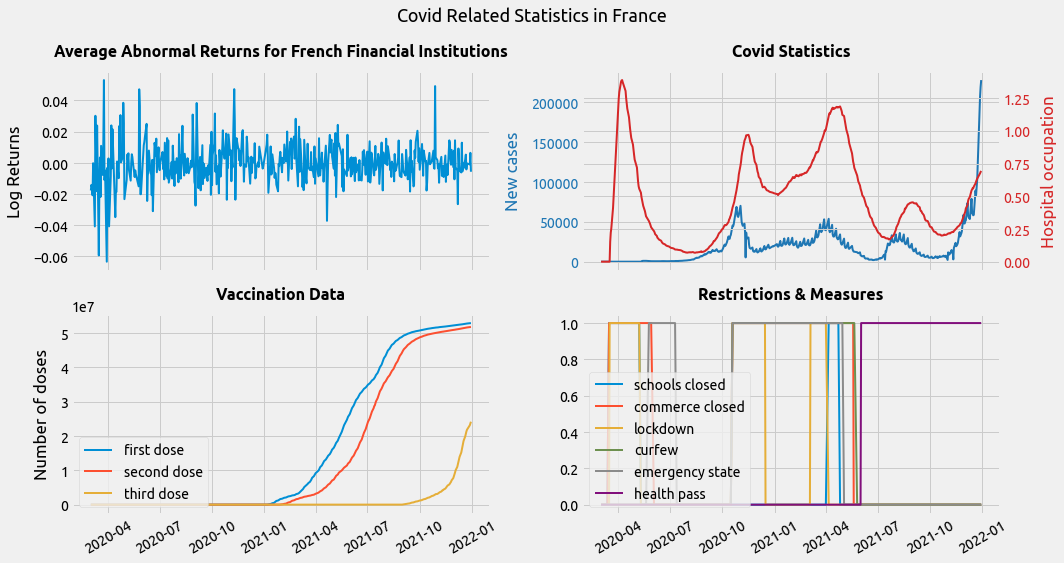

In [11]:
fig, ax = plt.subplots(2,2,sharex=True, figsize=(15,8))

ax[0,0].plot(df['date'], df['avg_abn_returns'])
ax[0,0].set_title('Average Abnormal Returns for French Financial Institutions')
ax[0,0].set_ylabel('Log Returns')

ax[1,0].plot(df['date'], df['n_first_dose'], df['date'], df['n_second_dose'], df['date'], df['n_third_dose'])
ax[1,0].legend(['first dose', 'second dose', 'third dose'], loc='lower left')
ax[1,0].set_title('Vaccination Data')
ax[1,0].set_ylabel('Number of doses')
ax[1,0].tick_params(axis='x', labelrotation = 30)

ax[0,1].plot(df['date'], df['n_cases'], c='tab:blue')
ax2 = ax[0,1].twinx()
ax2.plot(df['date'], df['hosp_occupation_rate'], c='tab:red')
ax[0,1].set_title('Covid Statistics')
ax[0,1].set_ylabel('New cases', color='tab:blue')
ax[0,1].tick_params(axis='y', labelcolor='tab:blue')
ax2.set_ylabel('Hospital occupation', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax[1,1].plot(
    df['date'], df['schools_closed'], 
    df['date'], df['restaurants_museums_closed'],
    df['date'], df['lockdown'],
    df['date'], df['curfew'],
    df['date'], df['emergency'],
    df['date'], df['health_pass']
)
ax[1,1].legend([
    'schools closed',
    'commerce closed',
    'lockdown',
    'curfew',
    'emergency state',
    'health pass'
], loc='lower left')
ax[1,1].set_title('Restrictions & Measures')
ax[1,1].tick_params(axis='x', labelrotation = 30)

fig.suptitle('Covid Related Statistics in France')
plt.tight_layout()
plt.show()

### Analysing correlation between variables

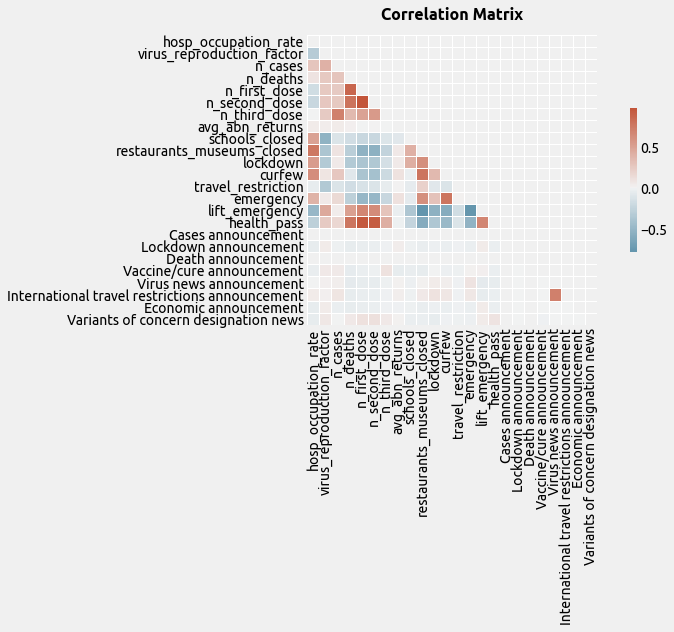

In [12]:
f, ax = plt.subplots(figsize=(11, 9))

corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    center=0,
    square=True,
    linewidths=.5, 
    cbar_kws={"shrink": .5}
    )

plt.title('Correlation Matrix')
plt.show()

## Treating Variables and Performing Tests

### Building variables of interest

Explanatory variables:
- Number of new positive cases (J-3): usually is reported on the news everyday, and it can impact on the prices of stocks (we can also check for the effect of past values)
- Hospital occupation rate: similar to the number of cases.
- Number of new vaccine doses: similar to the ones above.
- Covid related measures: dummy variables indicating the presence of a given restriction

Explained variable:
- Abnormal returns of top french financial stocks.

In [13]:
df['new_vaccines'] = (df['n_first_dose'] + df['n_second_dose'] + df['n_third_dose']).diff()
df.dropna(inplace=True)

### Applying an ADF-test to abnormal returns

In [14]:
adf_res = tsa.adfuller(df['avg_abn_returns'], regression='ct', regresults=True)

# Show test results
print(f"T-statistic: {adf_res[0]}")
print(f"P-value: {adf_res[1]}")
print(f"Used lag: {adf_res[3].usedlag}\n")
print(adf_res[3].resols.summary())

T-statistic: -11.165725160395464
P-value: 1.086658824971959e-17
Used lag: 3

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     97.99
Date:                Wed, 05 Jan 2022   Prob (F-statistic):           1.41e-69
Time:                        00:07:43   Log-Likelihood:                 1320.6
No. Observations:                 453   AIC:                            -2629.
Df Residuals:                     447   BIC:                            -2605.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

We can see that the test t-stat is low, so we reject the null hypothesis $\rho=0$. For this reason, we conclude that the series is stationary. We can also conclude that the series does not have drift nor trend, because its coefficients are not statistically significant.

## Regression Analysis - Abnormal Returns x Announcements

### Regression 1: Effect of announcements on abnormal returns

First, we will only consider the effects of announcements - impacts of news related to a specific measure. We also add a constant to account for time fixed effects (such as improvements in covid related treatment, health infrastructure, etc).

In [50]:
announcements = [
    'schools_closed',
    'restaurants_museums_closed',
    'lockdown',
    'curfew',
    'travel_restriction',
    'emergency',
    'health_pass'
]

X = df[announcements]
y = df['avg_abn_returns']

# get dummy for announcement days
for measure in announcements:
    X[measure] = X[measure].diff()
    
    # split into measure and ~measure
    if measure != 'health_pass':
        X[f'lift_{measure}'] = 1*(X[measure] == -1) 
    
    X[measure] = 1*(X[measure] == 1)

# drop nan values
nan = X.isna().any(axis=1) | y.isna()
X = X[~nan]
y = y[~nan]

/home/josebarretto/anaconda3/envs/ftd/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/josebarretto/anaconda3/envs/ftd/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/josebarretto/anaconda3/envs/ftd/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [51]:
model = sm.OLS(y, sm.add_constant(X))
res = model.fit()
res.summary()

/home/josebarretto/anaconda3/envs/ftd/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        avg_abn_returns   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     2.377
Date:                Wed, 05 Jan 2022   Prob (F-statistic):            0.00435
Time:                        00:29:44   Log-Likelihood:                 1344.6
No. Observations:                 457   AIC:                            -2661.
Df Residuals:                     443   BIC:                            -2604.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.0003      0.001      0.546      0.586      -0.001       0.002
schools_closed                      0.0014      0.018      0.076      0.940      -0.035       0.037
restaurants_museums_closed         -0.0610      0.022     -2.718      0.007      -0.105      -0.017
lockdown                           -0.0002      0.009     -0.020      0.984      -0.018       0.018
curfew                              0.0860      0.030      2.828      0.005       0.026       0.146
travel_restriction                 -0.0190      0.022     -0.845      0.399      -0.063       0.025
emergency                          -0.0154      0.013     -1.183      0.237      -0.041       0.010
health_pass                        -0.0090      0.013     -0.693      0.489      -0.034       0.017
lift_schools_closed                 0.0176      0.013      1.357      0.175      -0.008       0.043
lift_restaurants_museums_closed    -0.0185      0.013     -1.429      0.154      -0.044       0.007
lift_lockdown                      -0.0103      0.013     -0.796      0.426      -0.036       0.015
lift_curfew                        -0.0088      0.013     -0.676      0.499      -0.034       0.017
lift_travel_restriction             0.0295      0.018      1.610      0.108      -0.007       0.066
lift_emergency                     -0.0065      0.009     -0.704      0.482      -0.025       0.012
==============================================================================
Omnibus:                       41.952   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              180.430
Skew:                           0.231   Prob(JB):                     6.61e-40
Kurtosis:                       6.043   Cond. No.                         66.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can see that the only events that have significant effect:
- closing of restaurants and museum, negative impact to the abnormal returns. This can indicate that financial actors suffer when commercial and cultural activities are closed.
- implementation of a curfew, impacts positively on the abnormal returns. This can indicate that financial actors benefit from this measure.

It is also interesting that the lift of the measures did not impact on the abnormal returns. This indicates that the stock market does not react significantly to the lifting of covid measures.

### Regression 2: Effect of announcements on abnormal returns accounting for number of new cases and vaccination

Now, we include the number of daily cases, which is also commonly announced in the news.

In [52]:
X = pd.concat((X, df[['n_cases', 'new_vaccines']]), axis=1)
model = sm.OLS(y, sm.add_constant(X))
res = model.fit()
res.summary()

/home/josebarretto/anaconda3/envs/ftd/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        avg_abn_returns   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     2.107
Date:                Wed, 05 Jan 2022   Prob (F-statistic):            0.00887
Time:                        00:29:46   Log-Likelihood:                 1345.0
No. Observations:                 457   AIC:                            -2658.
Df Residuals:                     441   BIC:                            -2592.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.0003      0.001      0.299      0.765      -0.001       0.002
schools_closed                      0.0017      0.018      0.095      0.925      -0.035       0.038
restaurants_museums_closed         -0.0613      0.023     -2.711      0.007      -0.106      -0.017
lockdown                           -0.0002      0.009     -0.021      0.984      -0.018       0.018
curfew                              0.0854      0.031      2.786      0.006       0.025       0.146
travel_restriction                 -0.0189      0.023     -0.839      0.402      -0.063       0.025
emergency                          -0.0153      0.013     -1.175      0.240      -0.041       0.010
health_pass                        -0.0083      0.013     -0.637      0.525      -0.034       0.017
lift_schools_closed                 0.0179      0.013      1.371      0.171      -0.008       0.043
lift_restaurants_museums_closed    -0.0179      0.013     -1.377      0.169      -0.044       0.008
lift_lockdown                      -0.0106      0.013     -0.814      0.416      -0.036       0.015
lift_curfew                        -0.0065      0.013     -0.480      0.632      -0.033       0.020
lift_travel_restriction             0.0290      0.018      1.575      0.116      -0.007       0.065
lift_emergency                     -0.0062      0.009     -0.677      0.499      -0.024       0.012
n_cases                           2.17e-08   2.73e-08      0.795      0.427   -3.19e-08    7.54e-08
new_vaccines                     -1.12e-09   1.78e-09     -0.631      0.529   -4.61e-09    2.37e-09
==============================================================================
Omnibus:                       41.588   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              178.795
Skew:                           0.224   Prob(JB):                     1.50e-39
Kurtosis:                       6.031   Cond. No.                     3.15e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.15e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Interesting: results hold. Number of daily cases and vaccines not statistically significant.

### Regression 3: World News

Now, we consider a simple regression considering only global news and time-fixed effects.

In [53]:
global_news = [
    'Cases announcement',
    'Lockdown announcement',
    'Death announcement',
    'Vaccine/cure announcement',
    'Virus news announcement',
    'International travel restrictions announcement',
    'Economic announcement',
    'Variants of concern designation news'
]

X = pd.concat((X, df[global_news]), axis=1)

model = sm.OLS(y, sm.add_constant(X))
res = model.fit()
res.summary()

/home/josebarretto/anaconda3/envs/ftd/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        avg_abn_returns   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     1.590
Date:                Wed, 05 Jan 2022   Prob (F-statistic):             0.0478
Time:                        00:29:48   Log-Likelihood:                 1346.1
No. Observations:                 457   AIC:                            -2648.
Df Residuals:                     435   BIC:                            -2558.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                              0.0003      0.001      0.354      0.724      -0.001       0.002
schools_closed                                     0.0018      0.019      0.096      0.924      -0.035       0.038
restaurants_museums_closed                        -0.0614      0.023     -2.702      0.007      -0.106      -0.017
lockdown                                          -0.0002      0.009     -0.026      0.979      -0.018       0.018
curfew                                             0.0855      0.031      2.777      0.006       0.025       0.146
travel_restriction                                -0.0189      0.023     -0.834      0.405      -0.063       0.026
emergency                                         -0.0153      0.013     -1.174      0.241      -0.041       0.010
health_pass                                       -0.0083      0.013     -0.636      0.525      -0.034       0.017
lift_schools_closed                                0.0178      0.013      1.363      0.174      -0.008       0.044
lift_restaurants_museums_closed                   -0.0180      0.013     -1.373      0.170      -0.044       0.008
lift_lockdown                                     -0.0106      0.013     -0.814      0.416      -0.036       0.015
lift_curfew                                       -0.0064      0.014     -0.476      0.635      -0.033       0.020
lift_travel_restriction                            0.0289      0.018      1.567      0.118      -0.007       0.065
lift_emergency                                    -0.0063      0.009     -0.678      0.498      -0.024       0.012
n_cases                                         2.192e-08   2.76e-08      0.793      0.428   -3.24e-08    7.62e-08
new_vaccines                                   -1.155e-09   1.79e-09     -0.645      0.520   -4.68e-09    2.37e-09
Cases announcement                             -5.507e-18   6.53e-18     -0.843      0.400   -1.84e-17    7.34e-18
Lockdown announcement                              0.0091      0.013      0.700      0.484      -0.017       0.035
Death announcement                             -3.873e-18   2.58e-18     -1.502      0.134   -8.94e-18     1.2e-18
Vaccine/cure announcement                         -0.0061      0.006     -1.039      0.299      -0.018       0.005
Virus news announcement                           -0.0050      0.013     -0.382      0.703      -0.031       0.021
International travel restrictions announcement     0.0115      0.019      0.621      0.535      -0.025       0.048
Economic announcement                             -0.0034      0.013     -0.258      0.797      -0.029       0.022
Variants of concern designation news               0.0008      0.007      0.128      0.898   